In [1]:
# !pip install pyspark

### PASO 1: ¿Qué es PySpark?
PySpark es la interfaz de Apache Spark para Python. Te permite escribir código en Python que se ejecuta de forma paralela y distribuida sobre un clúster o sobre tu computador (modo local).

##### Spark fue diseñado para:

* Procesar grandes volúmenes de datos (Big Data)

* Ejecutar en paralelo usando muchos núcleos o computadores

* Ser compatible con SQL, Machine Learning y más

### PASO 2: Crear una sesión de PySpark (local)
La SparkSession es el punto de entrada para usar PySpark. En un sistema real, esa sesión se conecta a un clúster distribuido, pero en modo local usamos todos los núcleos del computador simulando ese comportamiento.

que son los cluster?

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("AnalisisClientes")
    .master("local[*]")
    .getOrCreate()
)


### Carga del dataset

In [3]:
# Cargar archivo CSV en PySpark
df = spark.read.csv("clientes_5M.csv", header=True, inferSchema=True)
# header=True indica que la primera fila tiene nombres de columnas.
# inferSchema=True permite que Spark detecte automáticamente los tipos de datos (int, string, etc).

### Analisis Exploratorio

In [5]:
# Ver primeras filas
df.show(5)

# Ver el esquema de columnas y tipos de datos
df.printSchema()

+----------+----+------------------+-----------------+------------+-------------+------------------+------------------+
|cliente_id|edad|ingresos_mensuales|nivel_educacional|      ciudad|usa_app_movil|compras_ultimo_mes|es_cliente_premium|
+----------+----+------------------+-----------------+------------+-------------+------------------+------------------+
|         1|  22|            643714|          Técnico|Punta Arenas|            1|                 7|                 1|
|         2|  44|            988727|          Técnico|Puerto Montt|            1|                 6|                 0|
|         3|  62|           1539536|          Técnico|  Concepción|            1|                 4|                 0|
|         4|  35|           1025008|          Técnico|  Valparaíso|            0|                 6|                 0|
|         5|  20|            869002|           Básica|  Concepción|            0|                 6|                 1|
+----------+----+------------------+----

In [6]:
# Contar filas del dataset
df.count()

10000000

In [7]:
# Estadisticos descriptivos
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+----------+-------------------+------------------+------------------+
|summary|        cliente_id|              edad|ingresos_mensuales|nivel_educacional|    ciudad|      usa_app_movil|compras_ultimo_mes|es_cliente_premium|
+-------+------------------+------------------+------------------+-----------------+----------+-------------------+------------------+------------------+
|  count|          10000000|          10000000|          10000000|         10000000|  10000000|           10000000|          10000000|          10000000|
|   mean|         5000000.5|        43.5074193|   1000053.8551141|             NULL|      NULL|          0.4998375|          5.000234|          0.149885|
| stddev|2886751.4902856923|15.009312578593784|  350019.825536585|             NULL|      NULL|0.49999999859374966|2.2357593889115264|0.3569586804056603|
|    min|                 1|                18|           -791181|          

In [8]:
# Distribucion de una variable categorica
df.groupBy("ciudad").count().orderBy("count", ascending=False).show()

+------------+-------+
|      ciudad|  count|
+------------+-------+
|      Temuco|1251835|
|    Valdivia|1251649|
|Punta Arenas|1250041|
|    Santiago|1249944|
|Puerto Montt|1249568|
|  Concepción|1249404|
|   La Serena|1249374|
|  Valparaíso|1248185|
+------------+-------+



In [9]:
# Promedio de ingresos por ciudad
from pyspark.sql.functions import avg

df.groupBy("ciudad").agg(avg("ingresos_mensuales").alias("prom_ingresos")).orderBy("prom_ingresos", ascending=False).show()

+------------+------------------+
|      ciudad|     prom_ingresos|
+------------+------------------+
|      Temuco|1000210.8781788335|
|    Santiago|1000175.3315692543|
|    Valdivia|1000147.3070493405|
|Punta Arenas|1000068.6447348527|
|  Concepción|1000014.9854410583|
|  Valparaíso| 999957.1490428102|
|   La Serena| 999938.5158335294|
|Puerto Montt|  999917.416363095|
+------------+------------------+



In [11]:
# Clientes premium por ciudad
df.groupBy("ciudad", "es_cliente_premium").count().orderBy("ciudad").show()

+------------+------------------+-------+
|      ciudad|es_cliente_premium|  count|
+------------+------------------+-------+
|  Concepción|                 0|1062968|
|  Concepción|                 1| 186436|
|   La Serena|                 1| 186739|
|   La Serena|                 0|1062635|
|Puerto Montt|                 0|1061661|
|Puerto Montt|                 1| 187907|
|Punta Arenas|                 0|1062235|
|Punta Arenas|                 1| 187806|
|    Santiago|                 0|1062513|
|    Santiago|                 1| 187431|
|      Temuco|                 0|1064337|
|      Temuco|                 1| 187498|
|    Valdivia|                 1| 187537|
|    Valdivia|                 0|1064112|
|  Valparaíso|                 1| 187496|
|  Valparaíso|                 0|1060689|
+------------+------------------+-------+



In [12]:
df.stat.corr("edad", "compras_ultimo_mes")


3.740668406328774e-05

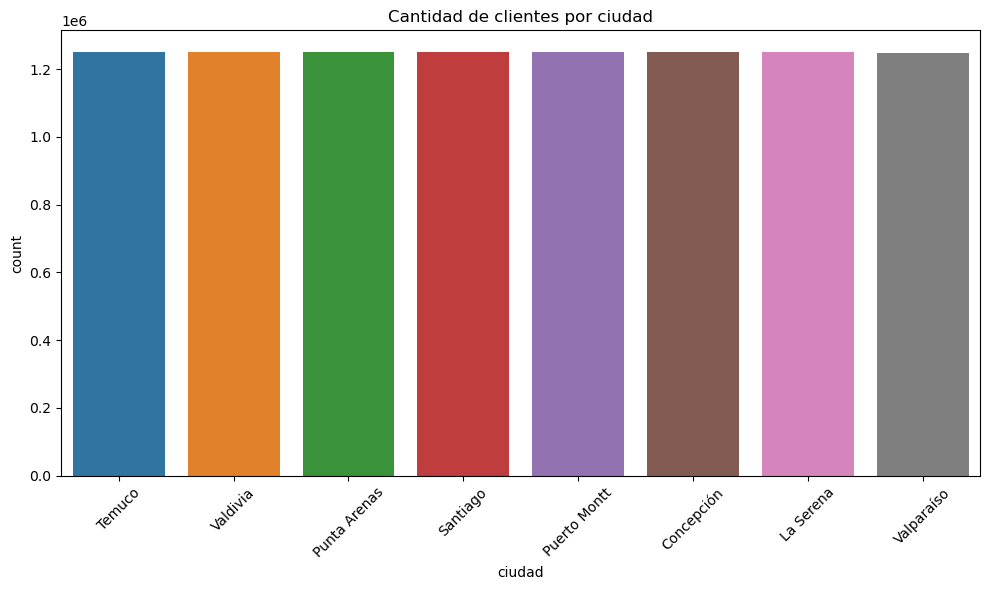

In [13]:
# Agrupamos y contamos clientes por ciudad
df_ciudades = df.groupBy("ciudad").count().orderBy("count", ascending=False)

# Convertimos a pandas
pdf_ciudades = df_ciudades.toPandas()

# Graficamos
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x="ciudad", y="count", data=pdf_ciudades)
plt.title("Cantidad de clientes por ciudad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


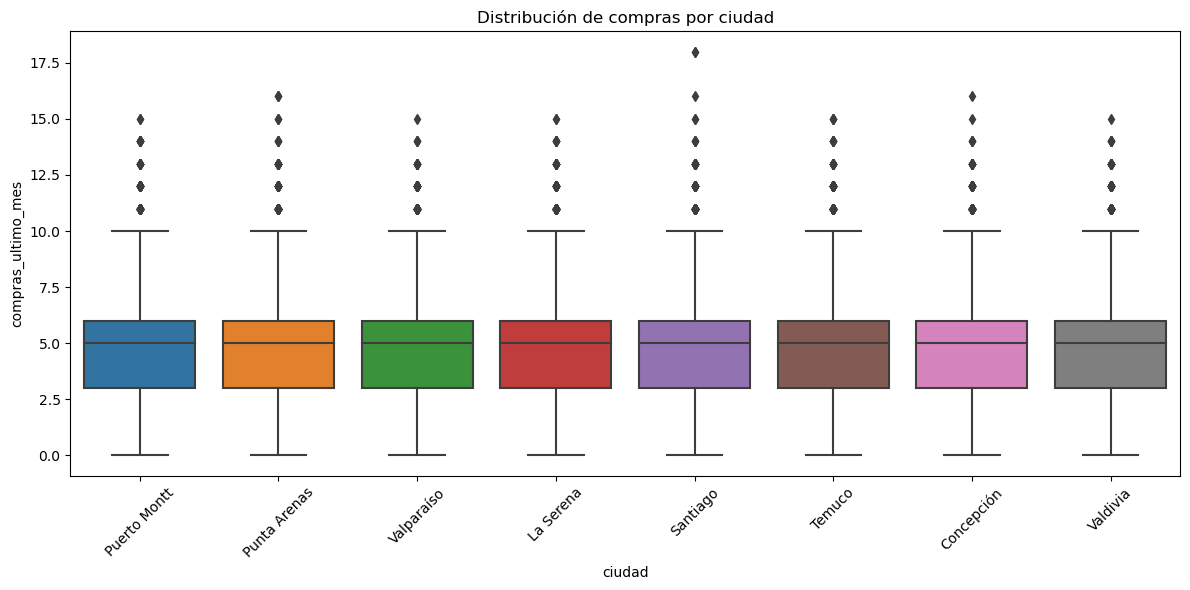

In [14]:
# Submuestreo (Spark → Pandas)
df_sample = df.select("ciudad", "compras_ultimo_mes").sample(fraction=0.01)
pdf_sample = df_sample.toPandas()

plt.figure(figsize=(12, 6))
sns.boxplot(x="ciudad", y="compras_ultimo_mes", data=pdf_sample)
plt.xticks(rotation=45)
plt.title("Distribución de compras por ciudad")
plt.tight_layout()
plt.show()


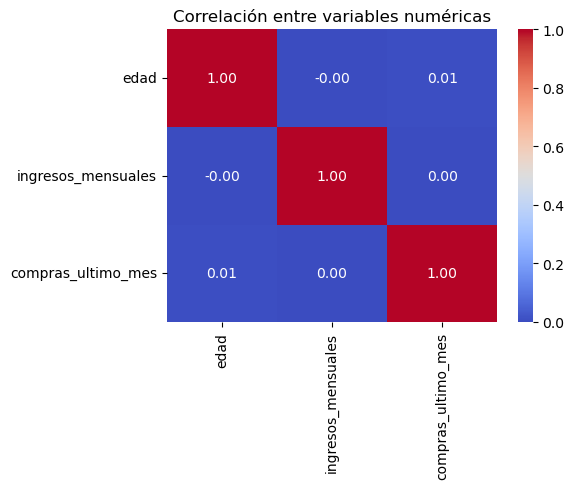

In [15]:
# Subset numérico
df_num = df.select("edad", "ingresos_mensuales", "compras_ultimo_mes")
pdf_num = df_num.sample(fraction=0.01).toPandas()

# Calcular matriz de correlación
corr = pdf_num.corr()

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.tight_layout()
plt.show()


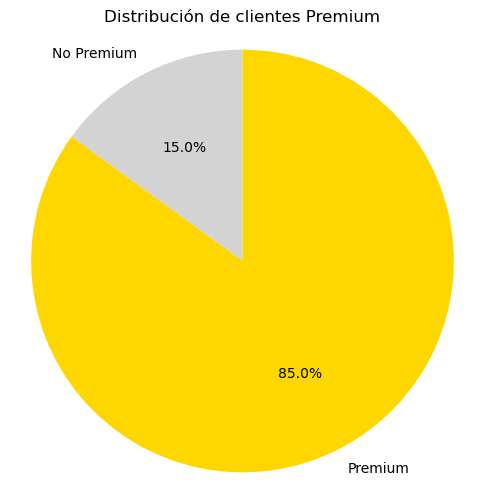

In [16]:
df_premium = df.groupBy("es_cliente_premium").count().toPandas()

labels = ["No Premium", "Premium"]
sizes = df_premium["count"]
colors = ["lightgray", "gold"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de clientes Premium")
plt.axis("equal")
plt.show()
